In [2]:
from typing import Dict
from typing import Union

import torch
import torch.distributions as tdist
from torch.utils.data import DataLoader


In [3]:
class ConvolvedDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        dataset_size: int,
        distribution: torch.distributions.Normal,
        input_dimension,
    ) -> None:
        self._dataset_size = dataset_size
        self._data_distribution = distribution
        self._input_dimension = input_dimension

        self._fixed_dataset = self._data_distribution.sample(
            (self._dataset_size, self._input_dimension)
        )

    def __len__(self):
        return self._dataset_size

    def __getitem__(self, idx):
        return self._fixed_dataset[idx]


    

In [5]:
import abc
from typing import Dict

import torch


class BaseData(abc.ABC):
    """Class for handling data

    Abstract methods that need to be implemented:

    - get_test_data
    - get_batch
    - signal_task_bounary_to_data_generator
    """

    def __init__(
        self, train_batch_size: int, test_batch_size: int, input_dimension: int
    ):
        """Class constructor"""
        self._train_batch_size = train_batch_size
        self._test_batch_size = test_batch_size
        self._input_dimension = input_dimension

    @abc.abstractmethod
    def get_test_data(self) -> Dict[str, torch.Tensor]:
        """returns fixed test data sets (data and labels)"""
        raise NotImplementedError("Base class method")

    @abc.abstractmethod
    def get_batch(self) -> Dict[str, torch.Tensor]:
        """returns batch of training data (input data and label if relevant)"""
        raise NotImplementedError("Base class method")


In [6]:
class ConvolvedData(BaseData):
    """Class for generating data convolved from multiple distributions."""

    def __init__(
        self,
        train_batch_size: int,
        test_batch_size: int,
        input_dimension: int,
        mean: Union[int, float],
        variance: Union[int, float],
        dataset_size: Union[str, int],
    ):
        super().__init__(
            train_batch_size=train_batch_size,
            test_batch_size=test_batch_size,
            input_dimension=input_dimension,
        )

        self._data_distribution = tdist.Normal(mean, variance)

        self._dataset_size = dataset_size

    def get_test_data(self) -> Dict[str, torch.Tensor]:
        """Give fixed test data set (input data only)."""
        test_input_data = self._data_distribution.sample(
            (self._test_batch_size, self._input_dimension)
        )

        test_data_dict = {"x": test_input_data}

        return test_data_dict

    def get_batch(self) -> Dict[str, torch.Tensor]:
        """Returns batch of training data (input only)"""
        batch = self._get_infinite_dataset_batch()
        return {"x": batch}

    def _get_finite_dataset_batch(self) -> torch.Tensor:
        try:
            batch = next(iter(self._data_iterator))
        except StopIteration:
            self._reset_data_iterator()
            batch = next(iter(self._data_iterator))
        return batch

    def _get_infinite_dataset_batch(self) -> torch.Tensor:
        #This is where we need to change the code
        batch = self._data_distribution.sample(
            (self._train_batch_size, self._input_dimension)
        )
        return batch

    def _reset_data_iterator(self):
        self._dataloader = DataLoader(
            self._dataset, batch_size=self._train_batch_size, shuffle=True
        )
        self._data_iterator = iter(self._dataloader)

In [9]:
dist = tdist.Normal(0, 1)
batch = dist.sample((1, 10))
print(batch)

tensor([[ 1.6522, -0.1500,  1.1884, -1.5021,  1.7391, -0.2363, -0.6828, -0.0296,
         -0.9045, -0.5971]])


In [14]:
dist = tdist.Uniform(0, 1)
batch = dist.sample((2, 10))
print(batch)

tensor([[0.5913, 0.0294, 0.4440, 0.0527, 0.4132, 0.3991, 0.7649, 0.4243, 0.8228,
         0.4196],
        [0.4653, 0.9533, 0.4380, 0.4892, 0.4921, 0.2982, 0.5418, 0.6130, 0.5040,
         0.2041]])


In [20]:
import numpy as np
print(np.arange(1, 10, 1))

[1 2 3 4 5 6 7 8 9]


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
import scipy as sp
import scipy.special
import random
import torch
def convolve_exp_norm(gamma, sigma, x, mu=0, tau=0):
    """
    Parameters:
    gamma = index of exponential
    mu = mean of the Gaussian (i.e. the centroid). If none-zero it is an offset
    sigma = std of normal distribution
    x = input value
    tau = pdf offset


    """
    co = (gamma/2.0) * np.exp( gamma*mu+ gamma*gamma*sigma*sigma/2.0)
    x_erf = (mu + gamma*sigma*sigma - x - tau)/(np.sqrt(2.0)*sigma)
    y = co * np.exp(-gamma*(x + tau)) * (1.0 - scipy.special.erf(x_erf))
    return y


In [31]:
convolve_exp_norm(1, 2, 0.5)


0.17953268548352722

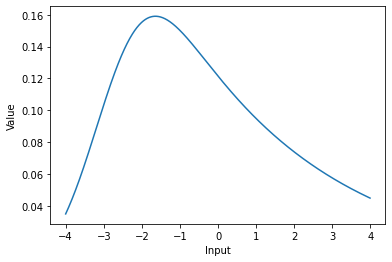

In [48]:
n = np.arange(-4, 4, 0.01)
y = [convolve_exp_norm(0.25, 1, _, -3, 0) for _ in n]

plt.plot(n, y)
#plt.grid()
plt.ylabel('Value')
plt.xlabel('Input')
plt.show()

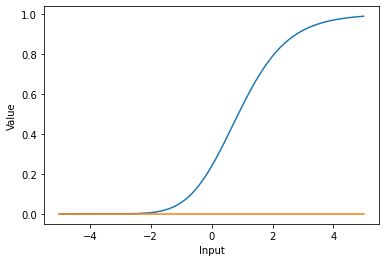

In [56]:
import scipy.integrate as integrate
import scipy.special as special
from pynverse import inversefunc

def convolved_cdf(p):
    result = integrate.quad(lambda x: convolve_exp_norm(1, 1, x), -5, p)
    return result

n = np.arange(-5, 5, 0.01)
y = [convolved_cdf(_) for _ in n]
plt.plot(n, y)
#plt.grid()
plt.ylabel('Value')
plt.xlabel('Input')
plt.show()

In [72]:
from scipy.stats import exponnorm


rv = exponnorm(0.5)
y = rv.rvs(size=10)
print(y)
#fig, ax = plt.subplots(1, 1)
#ax.hist(y, density=True, histtype='stepfilled', alpha=0.2)
#plt.show()

[ 0.62930939  0.74881468 -0.12665582  0.35068415  0.72966603  2.3305641
  1.60361976  0.69087     0.23625874 -0.2108672 ]


In [113]:
from scipy.stats import exponnorm
import time

start = time.time()
rv = exponnorm(0.5)
y = 1000
z = 500
x = [rv.rvs(size=y) for i in range(z)]

x = torch.FloatTensor(np.array(x)) 
x = x.apply_(lambda z: z*10)
end = time.time()
print(end-start)


0.07068061828613281
